# Описание задачи

Есть таблица с данными о займах выданных малому бизнесу в америке за часть 20 и 21 века.
В таблице есть данные о том был ли займ выплачен или нет.
Ставиться задача классификации: по данным займа определить будет ли он полностью выплачен или нет 

# Предобработка данных

In [1]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

In [2]:
data_raw = pd.read_csv('SBAnational.csv', low_memory=False)

In [3]:
data_raw.shape

(899164, 27)

In [4]:
data_raw.head(5)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [5]:
data_raw = data_raw.drop(columns=['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank','LowDoc', 'DisbursementGross', 'ChgOffPrinGr', 'BalanceGross'])

В признаке RevLineCr были найдены значению смысл которых нигде не описан, так как их количество крайне мало, следует оставить в датасете только "понятные" значения

In [6]:
bool_mask = data_raw['RevLineCr'] == 'N'
bool_mask |= data_raw['RevLineCr'] == '0' 
bool_mask |= data_raw['RevLineCr'] == 'Y' 
bool_mask |= data_raw['RevLineCr'] == 'T'

data_raw = data_raw[bool_mask]

Конвертация категориальных признаков для дальнейшей работы

In [7]:
def convert_from_str_to_float(column):
    column = column.str.removeprefix("$")
    column = column.str.removesuffix(" ")
    column = column.str.replace(',', '')
    column = column.astype('float64')

    return column

In [8]:
data_raw['State'] = data_raw['State'].astype('category')
data_raw['BankState'] = data_raw['BankState'].astype('category')
data_raw['MIS_Status'] = data_raw['MIS_Status'].astype('category')
data_raw['RevLineCr'] = data_raw['RevLineCr'].astype('category')

data_raw['GrAppv'] = convert_from_str_to_float(data_raw['GrAppv'])
data_raw['SBA_Appv'] = convert_from_str_to_float(data_raw['SBA_Appv'])

В столбце NAICS в первых двух цифрах закодировано значение индустрии, остальные цифры задают лишь уникальный номер предприятия

In [9]:
data_raw['NAICS'] = data_raw['NAICS'] // 10000
data_raw['NAICS'].astype('category')

data_raw = data_raw[data_raw['MIS_Status'].notna()]

С учётом специфики данной задачи можно все даты конвертировать в года и интерпретировать их как целое число, с которым сможет работать модель

In [10]:
data_raw['ApprovalDate'] = pd.to_datetime(data_raw['ApprovalDate'])
data_raw['ChgOffDate'] = pd.to_datetime(data_raw['ChgOffDate'])
data_raw['DisbursementDate'] = pd.to_datetime(data_raw['DisbursementDate'])

data_raw = data_raw[data_raw['ApprovalDate'] < pd.to_datetime('01.01.2020')]

def truncate_date_to_year(elem):
    if pd.isnull(elem):
        return 0
    return int(elem.year)

data_raw['ApprovalDate'] = data_raw['ApprovalDate'].apply(truncate_date_to_year)
data_raw['ChgOffDate'] = data_raw['ChgOffDate'].apply(truncate_date_to_year)
data_raw['DisbursementDate'] = data_raw['DisbursementDate'].apply(truncate_date_to_year)
data_raw['ApprovalDate'] = data_raw['ApprovalDate'].astype('int64')
data_raw['ChgOffDate'] = data_raw['ChgOffDate'].astype('int64')
data_raw['DisbursementDate'] = data_raw['DisbursementDate'].astype('int64')

def remove_strange_years(elem):
    if(elem == '1976A'):
        return '1976'
    return elem

data_raw['ApprovalFY'] = data_raw['ApprovalFY'].apply(remove_strange_years)
data_raw['ApprovalFY'].value_counts()
data_raw['ApprovalFY'] =  data_raw['ApprovalFY'].astype('int64')

/tmp/ipykernel_14089/2006507995.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_raw['ApprovalDate'] = pd.to_datetime(data_raw['ApprovalDate'])
/tmp/ipykernel_14089/2006507995.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_raw['ChgOffDate'] = pd.to_datetime(data_raw['ChgOffDate'])
/tmp/ipykernel_14089/2006507995.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_raw['DisbursementDate'] = pd.to_datetime(data_raw['DisbursementDate'])


# Анализ данных

In [11]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 892500 entries, 0 to 899163
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   State             892488 non-null  category
 1   BankState         890996 non-null  category
 2   NAICS             892500 non-null  int64   
 3   ApprovalDate      892500 non-null  int64   
 4   ApprovalFY        892500 non-null  int64   
 5   Term              892500 non-null  int64   
 6   NoEmp             892500 non-null  int64   
 7   NewExist          892366 non-null  float64 
 8   CreateJob         892500 non-null  int64   
 9   RetainedJob       892500 non-null  int64   
 10  FranchiseCode     892500 non-null  int64   
 11  UrbanRural        892500 non-null  int64   
 12  RevLineCr         892500 non-null  category
 13  ChgOffDate        892500 non-null  int64   
 14  DisbursementDate  892500 non-null  int64   
 15  MIS_Status        892500 non-null  category
 16  GrAppv 

In [12]:
data_raw.describe()

,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,ChgOffDate,DisbursementDate,GrAppv,SBA_Appv
count,892500.000000,892500.000000,892500.000000,892500.000000,892500.000000,892366.000000,892500.000000,892500.000000,892500.000000,892500.000000,892500.000000,892500.000000,8.925000e+05,8.925000e+05
mean,39.677844,2000.931888,2001.164375,110.740617,11.403408,1.280387,8.478839,10.857871,2756.506253,0.760371,365.009914,1996.344142,1.929508e+05,1.495664e+05
std,26.260497,5.898733,5.902185,78.879008,73.943503,0.451726,237.567853,238.000472,12764.290811,0.645955,774.422126,98.797043,2.830657e+05,2.278304e+05
min,0.000000,1973.000000,1973.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+03,5.000000e+02
25%,23.000000,1996.000000,1997.000000,60.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1997.000000,3.500000e+04,2.125000e+04
50%,44.000000,2002.000000,2003.000000,84.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2002.000000,9.000000e+04,6.160000e+04
75%,56.000000,2006.000000,2006.000000,120.000000,10.000000,2.000000,1.000000,4.000000,1.000000,1.000000,0.000000,2006.000000,2.250000e+05,1.750000e+05
max,92.000000,2014.000000,2014.000000,569.000000,9999.000000,2.000000,8800.000000,9500.000000,99999.000000,2.000000,2026.000000,2048.000000,5.000000e+06,4.500000e+06


In [13]:
data_raw.describe(include='category')

,State,BankState,RevLineCr,MIS_Status
count,892488,890996,892500,892500
unique,51,56,4,2
top,CA,CA,N,P I F
freq,129963,117603,419170,735128


По данным метрикам можно заметить, что во многих показателях присутствуют выбросы, их необходимо удалить

In [14]:
data_raw.head()

,State,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,ChgOffDate,DisbursementDate,MIS_Status,GrAppv,SBA_Appv
0,IN,OH,45,1997,1997,84,4,2.0,0,0,1,0,N,0,1999,P I F,60000.0,48000.0
1,IN,IN,72,1997,1997,60,2,2.0,0,0,1,0,N,0,1997,P I F,40000.0,32000.0
2,IN,IN,62,1997,1997,180,7,1.0,0,0,1,0,N,0,1997,P I F,287000.0,215250.0
3,OK,OK,0,1997,1997,60,2,1.0,0,0,1,0,N,0,1997,P I F,35000.0,28000.0
4,FL,FL,0,1997,1997,240,14,1.0,7,7,1,0,N,0,1997,P I F,229000.0,229000.0


Матрица корреляции

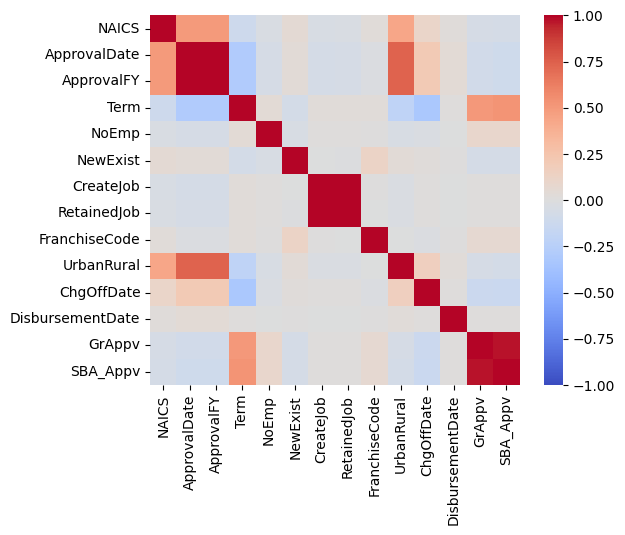

In [15]:
corr_mat = data_raw.corr(numeric_only=True)
sns.heatmap(corr_mat, square=True, vmin=-1, vmax=1, cmap='coolwarm')
pass

Как видно из корреляционной матрицы есть признаки которые сильное коррелируют, следовательно их можно удалить практически не теряя при этом данных о займе  

In [16]:
data_raw = data_raw.drop(columns=['ApprovalDate', 'RetainedJob', 'SBA_Appv'])

Борьба с выбросами

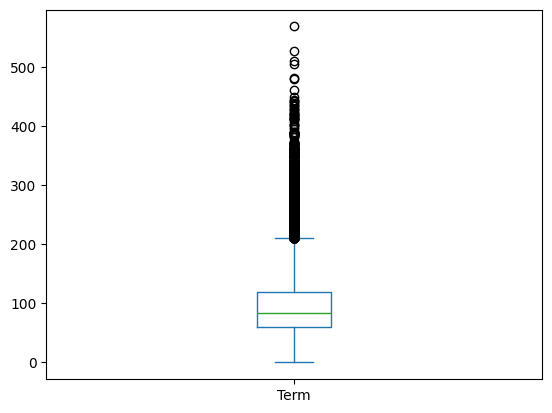

In [17]:
data_raw['Term'].plot(kind='box')
pass

In [18]:
data_raw = data_raw[data_raw['Term'].quantile(0.999) > data_raw["Term"]]

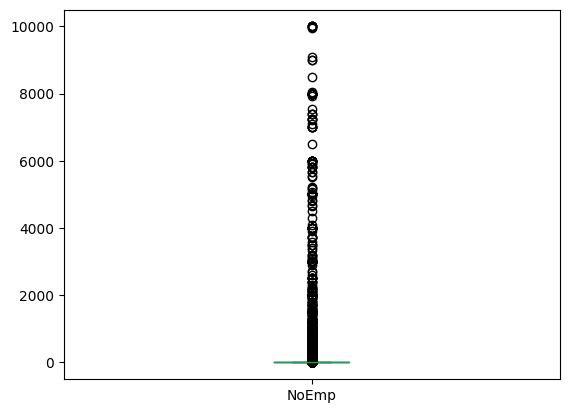

In [19]:
data_raw['NoEmp'].plot(kind='box')
pass

In [20]:
data_raw = data_raw[data_raw['NoEmp'].quantile(0.999) > data_raw['NoEmp']]

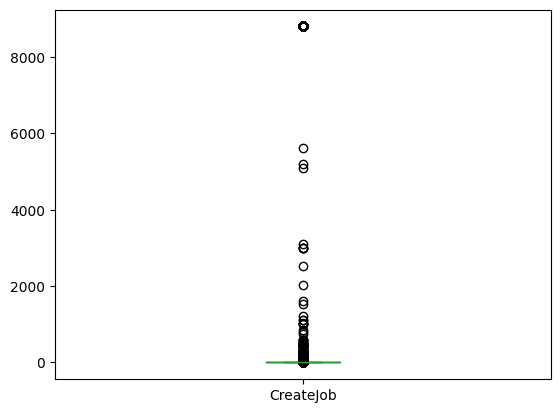

In [21]:
data_raw['CreateJob'].plot(kind='box')
pass

In [22]:
data_raw = data_raw[data_raw['CreateJob'].quantile(0.999) > data_raw['CreateJob']]

<Axes: >

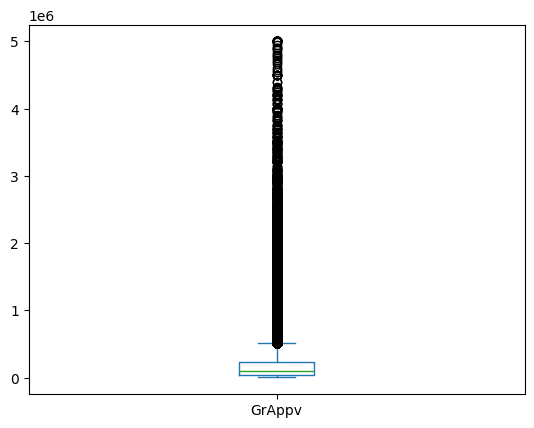

In [23]:
data_raw['GrAppv'].plot(kind='box')

In [24]:
data_raw = data_raw[data_raw['GrAppv'].quantile(0.99) > data_raw['GrAppv']]


Матрица рассеяния

In [25]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(data_raw, alpha = .01, figsize = (30, 30))
# pass

In [26]:
X = data_raw.drop(columns='MIS_Status')
y = data_raw['MIS_Status']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 13)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(748672, 132119)

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 748672 entries, 289599 to 500656
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   State             748663 non-null  category
 1   BankState         747403 non-null  category
 2   NAICS             748672 non-null  int64   
 3   ApprovalFY        748672 non-null  int64   
 4   Term              748672 non-null  int64   
 5   NoEmp             748672 non-null  int64   
 6   NewExist          748563 non-null  float64 
 7   CreateJob         748672 non-null  int64   
 8   FranchiseCode     748672 non-null  int64   
 9   UrbanRural        748672 non-null  int64   
 10  RevLineCr         748672 non-null  category
 11  ChgOffDate        748672 non-null  int64   
 12  DisbursementDate  748672 non-null  int64   
 13  GrAppv            748672 non-null  float64 
dtypes: category(3), float64(2), int64(9)
memory usage: 70.7 MB


Заполнение пустых значений

In [28]:
X_train.isnull().sum()

State                  9
BankState           1269
NAICS                  0
ApprovalFY             0
Term                   0
NoEmp                  0
NewExist             109
CreateJob              0
FranchiseCode          0
UrbanRural             0
RevLineCr              0
ChgOffDate             0
DisbursementDate       0
GrAppv                 0
dtype: int64

In [29]:
from sklearn.impute import SimpleImputer
columns_to_fill = ['State', 'BankState', 'NewExist']
most_freg_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
most_freg_imputer.fit(X_train[columns_to_fill])

X_train[columns_to_fill] = most_freg_imputer.transform(X_train[columns_to_fill])

Кодирование категориальных признаков с помощью OneHotEncoder

In [30]:
from sklearn.preprocessing import OneHotEncoder
columns_to_encode = ['State', 'BankState', 'NewExist', 'RevLineCr']
one_hot_encode = OneHotEncoder(drop='first', sparse_output=False)
one_hot_encode.fit(X_train[columns_to_encode])

dummies = pd.DataFrame(one_hot_encode.transform(X_train[columns_to_encode]),
                       columns=one_hot_encode.get_feature_names_out(), index=X_train.index)

X_train = pd.concat((X_train, dummies), axis=1).drop(columns_to_encode, axis=1)

Нормализация числовых признаков

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)

# Тренировка моделей и оценка результатов

In [32]:
X_test[columns_to_fill] = most_freg_imputer.transform(X_test[columns_to_fill])

dummies = pd.DataFrame(one_hot_encode.transform(X_test[columns_to_encode]),
                       columns=one_hot_encode.get_feature_names_out(), index=X_test.index)

X_test = pd.concat((X_test, dummies), axis=1).drop(columns_to_encode, axis=1)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)
pass

              precision    recall  f1-score   support

      CHGOFF       0.97      0.96      0.96     23221
       P I F       0.99      0.99      0.99    108898

    accuracy                           0.99    132119
   macro avg       0.98      0.98      0.98    132119
weighted avg       0.99      0.99      0.99    132119



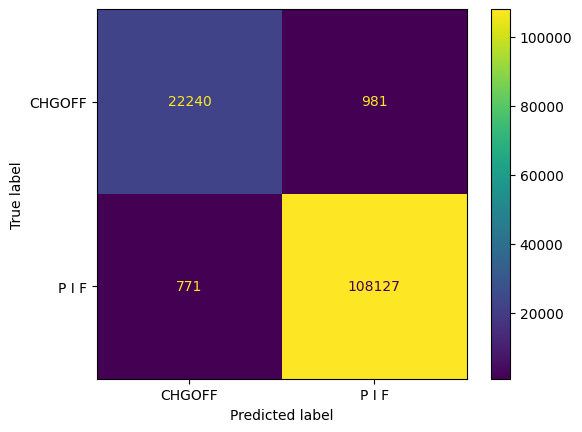

In [34]:
def plot_conf_matrix(y_test, y_pred):
    conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    disp = sklearn.metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=knn.classes_)

    disp.plot()

    print(sklearn.metrics.classification_report(y_test, y_pred))

y_pred = knn.predict(X_test)
plot_conf_matrix(y_test, y_pred)

По данным приведенным в таблице можно сделать вывод, что даже самая простая модель работает достаточно хорошо.
Скорее всего в данной задачи более "болезненными" являются ошибки 1 рода, а значит при дальнейшем подборе моделей и параметров можно поработать над уменьшением данных ошибок.

## Нейронная сеть

In [48]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(100,30), alpha=0.1)
model.fit(X_train, y_train)

MLPClassifier(alpha=0.1, hidden_layer_sizes=(100, 30))

              precision    recall  f1-score   support

      CHGOFF       0.97      1.00      0.98     23221
       P I F       1.00      0.99      1.00    108898

    accuracy                           0.99    132119
   macro avg       0.98      1.00      0.99    132119
weighted avg       0.99      0.99      0.99    132119



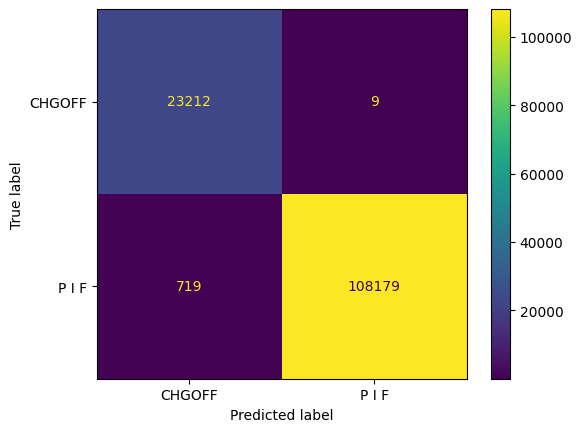

In [49]:
y_pred = model.predict(X_test)
plot_conf_matrix(y_test, y_pred)

## Подбор гиперпараметров для нейросети

In [50]:
layeres_size = []
for n_1 in np.arange(1, 101, 10):
    for n_2 in np.arange(1, 62, 10):
        layeres_size.append((n_1, n_2))

grid_space = {
    'hidden_layer_sizes' : layeres_size,
    'alpha' : list(np.arange(0.1, 1.01, 0.3))
}

In [52]:
from sklearn.model_selection import RandomizedSearchCV

grid = RandomizedSearchCV(model, grid_space, n_iter=10)
model_grid = grid.fit(X_train, y_train)

In [54]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'hidden_layer_sizes': (31, 61), 'alpha': 0.4}
Best score is: 0.9943660238639886


Подставим найденные гиперпараметры в модель

In [55]:
model = MLPClassifier(hidden_layer_sizes=(31, 61), alpha=0.4)
model.fit(X_train, y_train)

MLPClassifier(alpha=0.4, hidden_layer_sizes=(31, 61))

              precision    recall  f1-score   support

      CHGOFF       0.97      1.00      0.98     23221
       P I F       1.00      0.99      1.00    108898

    accuracy                           0.99    132119
   macro avg       0.98      1.00      0.99    132119
weighted avg       0.99      0.99      0.99    132119



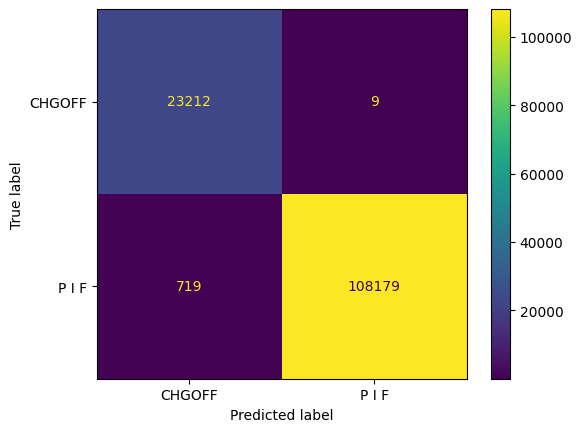

In [56]:
y_pred = model.predict(X_test)
plot_conf_matrix(y_test, y_pred)

Как можно заметить после очень долго подбора гиперпараметров, результат никак не изменился, следовательно следует использовать небольшую нейронную сеть для уменьшения использования вычислительных ресурсов. 

## Логистическая регресия

In [39]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

      CHGOFF       0.97      1.00      0.98     23221
       P I F       1.00      0.99      1.00    108898

    accuracy                           0.99    132119
   macro avg       0.98      1.00      0.99    132119
weighted avg       0.99      0.99      0.99    132119



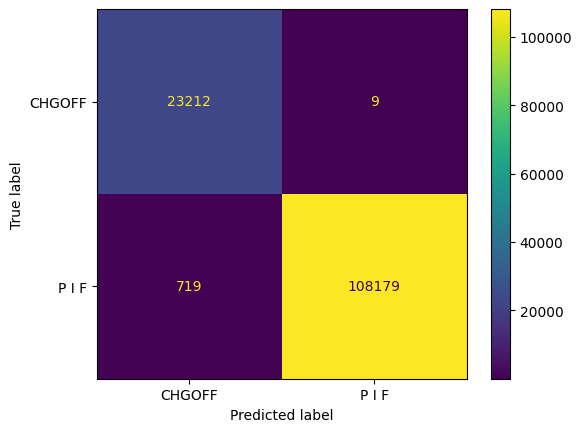

In [40]:
y_pred = model.predict(X_test)
plot_conf_matrix(y_test, y_pred)

## Случайный лес

In [41]:
from sklearn.ensemble import RandomForestRegressor

y_train_num = (y_train != 'CHGOFF')
y_train_num = y_train_num.astype(np.float32, copy=False)
# print(y_train_num.shape, X_train.shape)

model = RandomForestRegressor()
model.fit(X_train, y_train_num)

RandomForestRegressor()

              precision    recall  f1-score   support

       False       0.97      1.00      0.98     23221
        True       1.00      0.99      1.00    108898

    accuracy                           0.99    132119
   macro avg       0.98      1.00      0.99    132119
weighted avg       0.99      0.99      0.99    132119



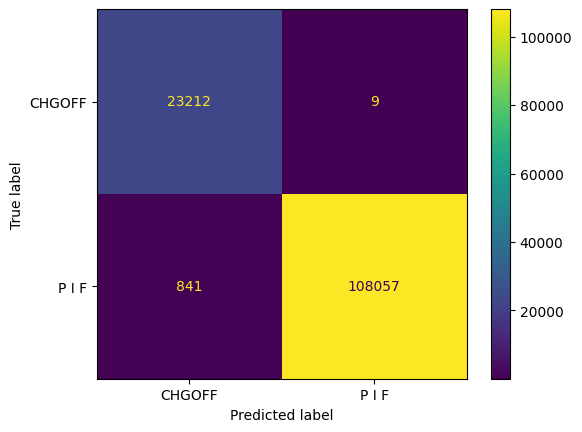

In [42]:
y_pred = model.predict(X_test) == 1.0

y_test_num = (y_test != 'CHGOFF')

plot_conf_matrix(y_test_num.to_numpy(), y_pred)

## Вывод

Из рассмотренных моделей и результатами, которые они показали, можно сделать вывод, что с данной задачей методы машинного обучения справляются достаточно хорошо.
Все модели практически не ошибаются в случае, когда займ не будет погашен, но имеют чуть больший процент ошибок в случае когда займ будет погашен (но всё ещё достаточно маленький), однако с точки зрения прикладной задачи ошибки второго рода имеет гораздо меньшее значение, чем ошибки первого рода

Так же из полученных результатов можно сделать вывод, что все модели, кроме случайного леса, ведут себя практически одинаково, в том числе и когда меняются гиперпараметры, это значит для решения задачи можно использовать модели "попроще".

Так как все модели показывали хорошие результаты на тестовой выборке можно сделать вывод, что переобучение ни на одной модели не наблюдалось